In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from backtest import *

In [2]:
backtest_df = pd.read_parquet('data.parquet')

In [3]:
backtest_df.head()

,ask_rate,ask_amount,bid_rate,bid_amount,midprice,target,signal
2019-10-09 09:30:03.365,"[336.42, 336.43, 336.49, 336.54, 336.6]","[3.41067, 19.41908, 8.91917, 12.0, 19.96468]","[336.22, 336.19, 336.17, 336.12, 333.1]","[11.51755, 1.48644, 27.35777, 74.1057, 5.55105]",336.320,0.015,-0.004417
2019-10-09 09:30:03.465,"[336.42, 336.43, 336.49, 336.51, 336.54]","[3.41067, 27.97455, 8.91917, 5.99121, 12.0]","[336.22, 336.21, 336.19, 336.17, 336.16]","[11.51755, 125.39419, 1.48644, 27.35777, 18.9743]",336.320,0.015,-0.004417
2019-10-09 09:30:03.565,"[336.42, 336.43, 336.49, 336.51, 336.52]","[3.41067, 27.97455, 8.91917, 5.99121, 13.0]","[336.23, 336.22, 336.21, 336.17, 336.16]","[6.27933, 11.51755, 125.39419, 27.35777, 18.9743]",336.325,0.025,-0.004417
2019-10-09 09:30:03.665,"[336.42, 336.43, 336.47, 336.49, 336.51]","[3.41067, 27.97455, 24.91138, 8.91917, 5.99121]","[336.23, 336.22, 336.21, 336.17, 336.16]","[6.27933, 11.51755, 125.39419, 27.35777, 18.9743]",336.325,0.030,-0.004417
2019-10-09 09:30:03.765,"[336.42, 336.43, 336.47, 336.49, 336.5]","[3.41067, 27.97455, 24.91138, 15.1988, 31.96246]","[336.25, 336.23, 336.22, 336.21, 336.17]","[8.98892, 8.67933, 9.11755, 125.39419, 27.35777]",336.335,0.020,-0.004417


# Статегия

Первым критерием для покупки считается ```signal > 0.095```,на продажу ```signal < 0.115``` (Значения подобраны по гистограмме для отсеивания шума и сигналов на слишком малые изменения цены сделки по которым будут съедены комиссией).

Второй критерий: ```ask_amount[0] - bid_amount[0] < -8 - покупка; > 8 - продажа``` - разница ask-bid говорит о большом скоплении объема в одном направлении, что повышает вероятность отскока от этого уровня.

При открытии позиции в лонг объем сделки равен позиции в шорт при ее наличии + размер позиции, в шорт - аналогично
```-current_position + trade_size```

In [4]:
def custom_strategy(strategy_state, orderbook_state, trade_size, storage, max_position=1):
    '''
    Описание стратегии
    --------------
    Совершает покупку, если (signal > 0.095 and amount_diff < -8) итекущая абсолютная позиция меньше
    максимальной.
    Совершает продажу, если (signal < 0.115 and amount_diff > 8) и текущая абсолютная позиция меньше
    максимальной.
    
    Параметры
    --------------
    strategy_state : list
        Массив, содержащий index (номер тика), current_position (текущую позицию)
        и signal (сигнал модели для данного тика).
    orderbook_state : list
        Массив, содержащий информацию о стакане для данного тика.
    trade_size : float
        Объем одной сделки.
    storage : dict
        Словарь для сохранения информации с прошлых тиков.
    max_position : int
        Максимальный объем открытой позиции в одну сторону. Должен быть равен 1.
    
    Результат
    --------------
    order_size : float
        Стратегия возвращает объем сделки, где знак обозначает сторону сделки: 
        положительный для покупки и отрицательный для продажи
    '''
    index, current_position, signal = strategy_state
    ask_rate, ask_amount, bid_rate, bid_amount = orderbook_state
    
    amount_diff = ask_amount[0] - bid_amount[0]

    order_size = 0

    if ((signal > 0.095)
        and (amount_diff < -8)
       ):  # покупка
        if current_position < 0:
            order_size = -current_position
            
        order_size += min(trade_size, max_position - current_position)  # определение объема сделки


    elif ((signal < -0.115)
          and (amount_diff > 8)
         ):  # продажа
        
        if current_position > 0:
            order_size = -current_position
            
        order_size += -min(trade_size, max_position + current_position)  # определение объема сделки

    
    return order_size

In [5]:
strategy_params = {}
strategy_params['trade_size'] = 1  # максимальное значение = 1
strategy_params['storage'] = {}

{'pnl': 133.66675740000022, 'pnl_after_fee': 119.97727113834013, 'actions': 206}


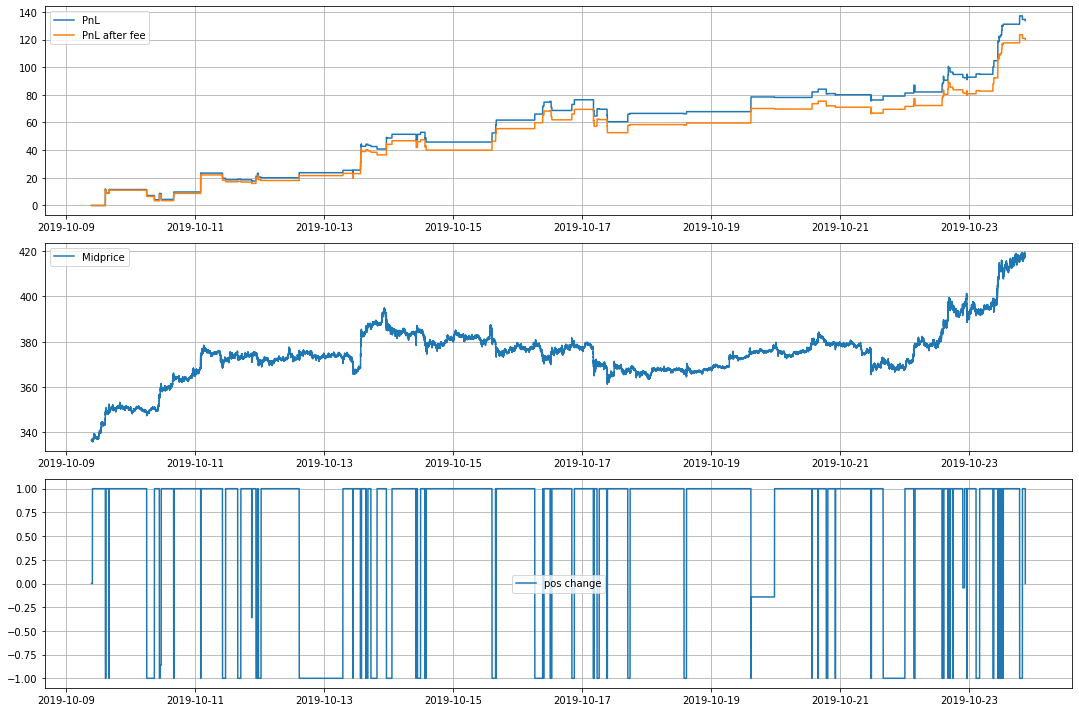

CPU times: user 52.9 s, sys: 2.37 s, total: 55.2 s
Wall time: 55 s


<Figure size 432x288 with 0 Axes>

In [6]:
%%time
summary, result = backtest(backtest_df, custom_strategy, strategy_params, viz=True)